In [ ]:
!pip install replay-rec rs_datasets --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from replay.splitters import TimeSplitter
from replay.preprocessing.filters import MinCountFilter, LowRatingFilter
from replay.data import Dataset, FeatureHint, FeatureInfo, FeatureSchema, FeatureType
from replay.metrics import HitRate, NDCG, Coverage, Coverage, Experiment
from replay.models import CatPopRec
from replay.utils.spark_utils import convert2spark
from rs_datasets import MovieLens
from typing import Iterable

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Практика. Неперсонализированные алгоритмы

In [ ]:
K = 10
SEED = 13
USER_COL = "user_id"
ITEM_COL = "item_id"
RATING_COL = "rating"
TIMESTAMP_COL = "timestamp"
np.random.seed(SEED)

In [ ]:
data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [ ]:
ratings, items = data.ratings, data.items

In [ ]:
ratings[TIMESTAMP_COL] = pd.to_datetime(ratings[TIMESTAMP_COL], unit="s")

## EDA

In [ ]:
ratings.head(5)

,user_id,item_id,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [ ]:
items.head(5)

,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


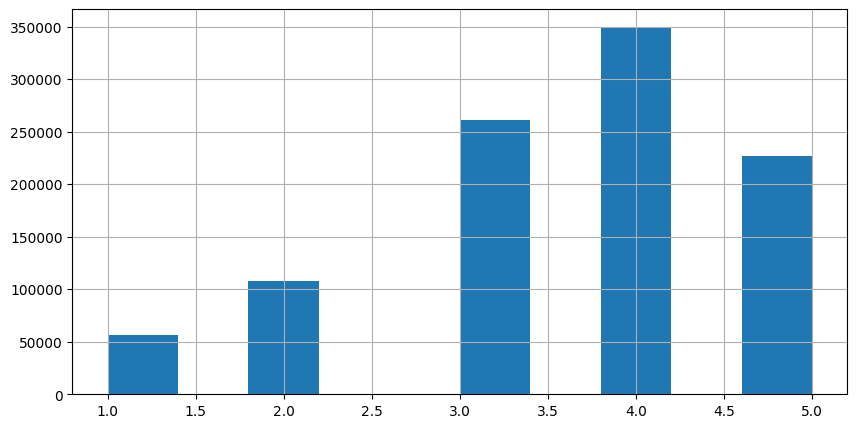

In [ ]:
ratings[RATING_COL].hist(bins=10, figsize=(10, 5));

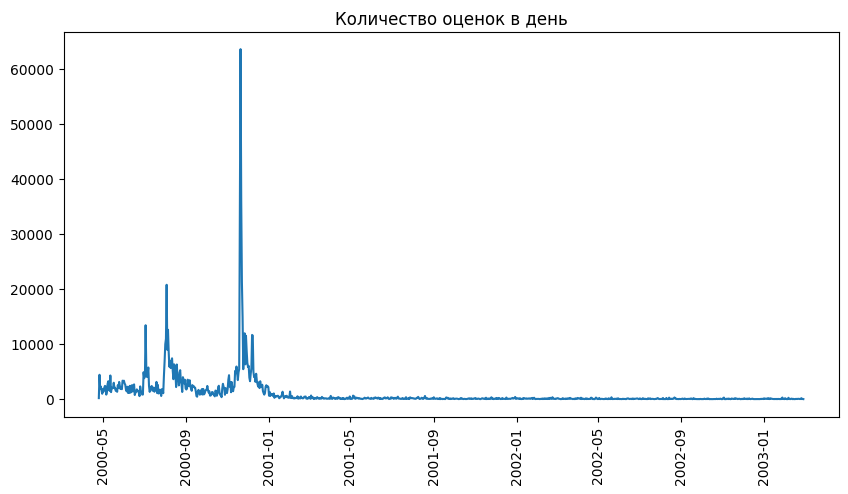

In [ ]:
ratings[TIMESTAMP_COL].dt.date.value_counts().plot(
    figsize=(10, 5), rot="vertical", title="Количество оценок в день"
);

In [ ]:
def describe_and_plot(df, alpha=0.99, title=""):
    print(df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))
    df[df < df.quantile(alpha)].plot(kind="hist", bins=50, figsize=(10, 5), title=title)

In [ ]:
def group_by_and_plot(df, group_by_name, rating_col_name, alpha=0.99, title=""):
    grouped = df.groupby(group_by_name)[rating_col_name].count()
    describe_and_plot(grouped, alpha, title)
    return grouped

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
5%         23.000000
25%        44.000000
50%        96.000000
75%       208.000000
95%       556.000000
max      2314.000000
Name: rating, dtype: float64


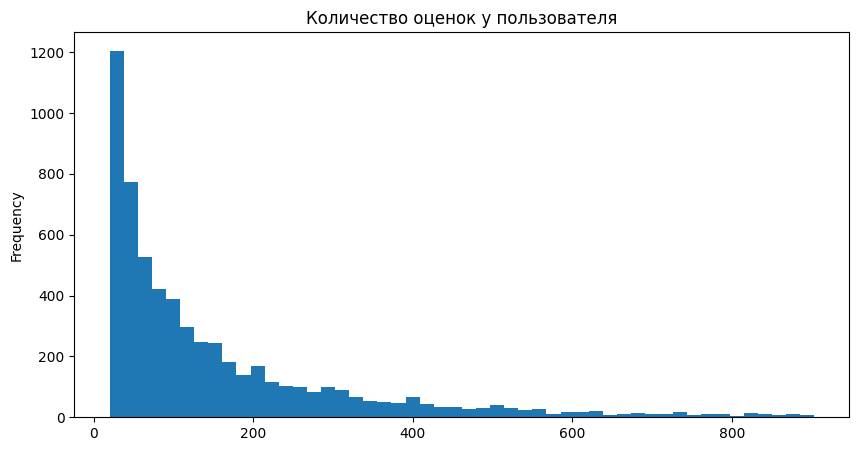

In [ ]:
user_count = group_by_and_plot(
    ratings,
    group_by_name=USER_COL,
    rating_col_name=RATING_COL,
    alpha=0.99,
    title="Количество оценок у пользователя",
)

count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
5%          2.000000
25%        33.000000
50%       123.500000
75%       350.000000
95%      1051.500000
max      3428.000000
Name: rating, dtype: float64


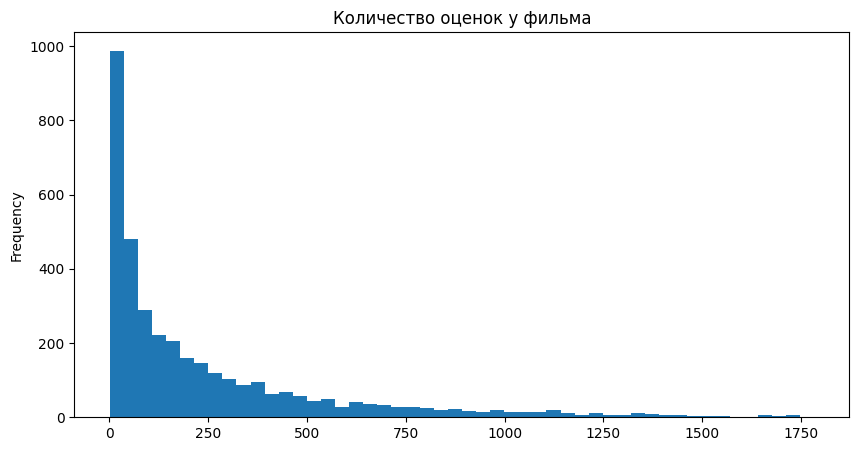

In [ ]:
item_count = group_by_and_plot(
    ratings,
    group_by_name=ITEM_COL,
    rating_col_name=RATING_COL,
    alpha=0.99,
    title="Количество оценок у фильма",
)

## Предобработка данных

In [ ]:
ratings.shape[0]

1000209

In [ ]:
ratings = MinCountFilter(num_entries=20, groupby_column=ITEM_COL).transform(ratings)
ratings.shape[0]

995492

In [ ]:
print(f"Количество уникальных пользователей: {ratings[USER_COL].nunique()}")
print(f"Количество уникальных фильмов: {ratings[ITEM_COL].nunique()}")

Количество уникальных пользователей: 6040
Количество уникальных фильмов: 3043


In [ ]:
train, test = TimeSplitter(
    time_threshold=0.2,
    query_column=USER_COL,
    item_column=ITEM_COL,
    drop_cold_users=True,
    drop_cold_items=True,
).split(ratings)
train.shape, test.shape

((796392, 4), (103764, 4))

In [ ]:
test = LowRatingFilter(value=4, rating_column=RATING_COL).transform(test)
test.shape

(55988, 4)

## Неперосонализированные рекомендательные модели

### Случайные рекомендации

Случайные рекомендации - это самая простая модель рекомендаций, с которой всегда стоит сравниваться. Продукты выбираются случайным образом из всего каталога, релевантности также можно определить случайным образом или задать как обратную позицию в случайно сгенерированной выборке.

In [ ]:
random_recs = np.random.choice(items[ITEM_COL].values, size=K, replace=False)

In [ ]:
items[items[ITEM_COL].isin(random_recs)]

,item_id,title,genres
814,825,Echte Kerle (1996),Comedy|Romance
909,921,My Favorite Year (1982),Comedy
1388,1411,Hamlet (1996),Drama
1525,1565,Head Above Water (1996),Comedy|Thriller
1562,1603,Mimic (1997),Sci-Fi|Thriller
2411,2480,Dry Cleaning (Nettoyage à sec) (1997),Drama
2652,2721,Trick (1999),Romance
2911,2980,Men Cry Bullets (1997),Drama
3556,3625,Better Living Through Circuitry (1999),Documentary
3850,3920,"Faraway, So Close (In Weiter Ferne, So Nah!) (...",Drama|Fantasy


#### Построение рекомендаций

In [ ]:
random_recs = test[[USER_COL]].drop_duplicates().reset_index(drop=True)
random_recs.head(2)

,user_id
0,636
1,795


In [ ]:
def get_random_recs(df, K):
    return list(
        zip(
            np.random.choice(items[ITEM_COL].values, size=K, replace=False),
            [1 / i for i in range(1, K + 1)],
        )
    )

In [ ]:
random_recs["recs"] = random_recs.apply(get_random_recs, K=K, axis=1)

In [ ]:
random_recs.head(2)

,user_id,recs
0,636,"[(193, 1.0), (1358, 0.5), (3393, 0.33333333333..."
1,795,"[(1956, 1.0), (3042, 0.5), (2076, 0.3333333333..."


In [ ]:
def explode_recs(df):
    df = df.explode("recs")
    df[ITEM_COL] = df["recs"].apply(lambda x: x[0])
    df["score"] = df["recs"].apply(lambda x: x[1])
    return df.drop(columns=["recs"]).reset_index(drop=True)

In [ ]:
random_recs = explode_recs(random_recs)
random_recs.head(2)

,user_id,item_id,score
0,636,193,1.0
1,636,1358,0.5


#### Подсчет метрик

In [ ]:
metrics = Experiment(
    [NDCG(K), HitRate(K), Coverage(K)],
    test,
    train,
    query_column=USER_COL,
    item_column=ITEM_COL,
    rating_column="score",
)

In [ ]:
metrics.add_result("RandomRec", random_recs)
metrics.results

,NDCG@10,HitRate@10,Coverage@10
RandomRec,0.013593,0.105357,0.938836


### Рекомендации популярного

Попробуем рекомендовать популярные товары. Популярность товара - это число взаимодействий с товаром, в нашем случае количество оценок у фильма.

#### Подсчет популярности

In [ ]:
popularity = train[ITEM_COL].value_counts()
popularity[:K]

,item_id
2858,2901
1196,2515
260,2513
1210,2456
589,2283
2028,2245
480,2232
1270,2183
2571,2172
1580,2156


In [ ]:
items["popularity"] = items[ITEM_COL].map(popularity).fillna(0)

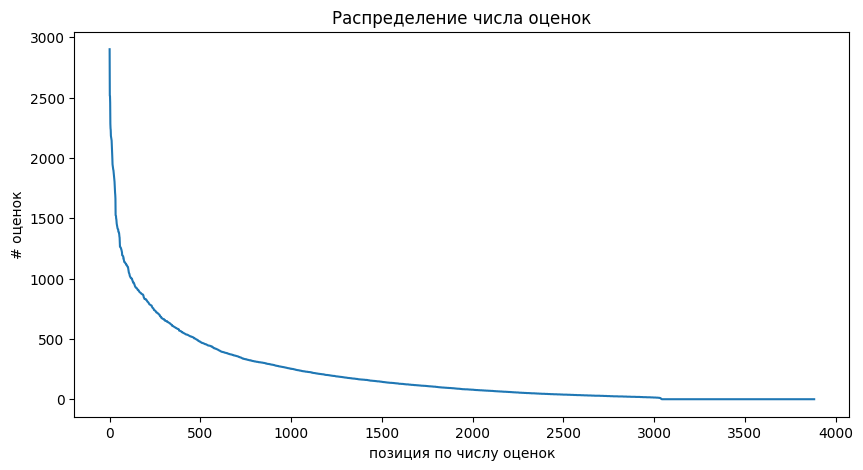

In [ ]:
items["popularity"].sort_values(ascending=False).reset_index(drop=True).plot(
    figsize=(10, 5),
    ylabel="# оценок",
    xlabel="позиция по числу оценок",
    title="Распределение числа оценок",
);

#### Самые популярные фильмы

In [ ]:
popular_items = items[items[ITEM_COL].isin(popularity[:K].index.values)]
popular_items.sort_values(by=["popularity"], ascending=False)

,item_id,title,genres,popularity
2789,2858,American Beauty (1999),Comedy|Drama,2901.0
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,2515.0
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,2513.0
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,2456.0
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,2283.0
1959,2028,Saving Private Ryan (1998),Action|Drama|War,2245.0
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,2232.0
1250,1270,Back to the Future (1985),Comedy|Sci-Fi,2183.0
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,2172.0
1539,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,2156.0


#### Построение рекомендаций

In [ ]:
pop_recs = test[[USER_COL]].drop_duplicates().reset_index(drop=True)
pop_recs[ITEM_COL] = pop_recs.apply(lambda x: popularity.index.values[:K], axis=1)
pop_recs.head(2)

,user_id,item_id
0,636,"[2858, 1196, 260, 1210, 589, 2028, 480, 1270, ..."
1,795,"[2858, 1196, 260, 1210, 589, 2028, 480, 1270, ..."


In [ ]:
pop_recs = pop_recs.explode(ITEM_COL)
pop_recs["score"] = pop_recs[ITEM_COL].map(popularity).fillna(0)
pop_recs.reset_index(drop=True, inplace=True)

In [ ]:
pop_recs[:12]

,user_id,item_id,score
0,636,2858,2901
1,636,1196,2515
2,636,260,2513
3,636,1210,2456
4,636,589,2283
5,636,2028,2245
6,636,480,2232
7,636,1270,2183
8,636,2571,2172
9,636,1580,2156


#### Подсчет метрик

In [ ]:
metrics.add_result("PopRec", pop_recs)
metrics.results.sort_values("NDCG@10", ascending=False)

,NDCG@10,HitRate@10,Coverage@10
PopRec,0.098545,0.394643,0.003288
RandomRec,0.013593,0.105357,0.938836


#### Добавим новизны

Рассмотрим пользователя, который ранее уже проставил много оценок фильмам

In [ ]:
USER_ID = 872
user_hist = train[train[USER_COL] == USER_ID]
user_recs = pop_recs[pop_recs[USER_COL] == USER_ID]
user_hist.shape[0]

82

Насколько наши рекомендации актуальны для него?

In [ ]:
user_recs[~user_recs[ITEM_COL].isin(user_hist[ITEM_COL])]

,user_id,item_id,score
10053,872,1210,2456
10055,872,2028,2245
10057,872,1270,2183


Мы рекомендуем только три фильма, которые пользователь не оценивал ранее. Сделаем фильтрацию просмотренных товаров при формировании рекомендаций.

#### Построение рекомендаций с учетом фильтрации просмотренных

In [ ]:
test_users_hist = (
    train[train[USER_COL].isin(test[USER_COL].unique())]
    .groupby(USER_COL)[ITEM_COL]
    .agg(set)
)

In [ ]:
pop_recs_filter = test[[USER_COL]].drop_duplicates().reset_index(drop=True)
pop_recs_filter["history"] = pop_recs_filter[USER_COL].map(test_users_hist)

In [ ]:
def get_pop_recs_with_filter(df, K, pop_data):
    if isinstance(df["history"], Iterable):
        candidates = pop_data.index[: K + len(df["history"])]
        return candidates[~candidates.isin(df["history"])][:K].values
    return pop_data.index[:K].values

In [ ]:
pop_recs_filter[ITEM_COL] = pop_recs_filter.apply(
    get_pop_recs_with_filter, K=K, pop_data=popularity, axis=1
)
pop_recs_filter.drop(columns="history", inplace=True)

In [ ]:
pop_recs_filter = pop_recs_filter.explode(ITEM_COL)
pop_recs_filter["score"] = pop_recs_filter[ITEM_COL].map(popularity).fillna(0)
pop_recs_filter.reset_index(drop=True, inplace=True)

In [ ]:
metrics.add_result("PopRec filtered", pop_recs_filter)
metrics.results.sort_values("NDCG@10", ascending=False)

,NDCG@10,HitRate@10,Coverage@10
PopRec filtered,0.214737,0.633036,0.044722
PopRec,0.098545,0.394643,0.003288
RandomRec,0.013593,0.105357,0.938836


Представленные выше модели также [реализованы](https://sb-ai-lab.github.io/RePlay/pages/useful_data/algorithm_selection.html#) в библиотеке RePlay. Ниже перечислены некоторые неперсонализированные модели, которые есть в RePlay:
* [Popular Recommender](https://sb-ai-lab.github.io/RePlay/pages/modules/models.html#replay.models.PopRec);
* [Random Recommender](https://sb-ai-lab.github.io/RePlay/pages/modules/models.html#replay.models.RandomRec);
* [Wilson Recommender](https://sb-ai-lab.github.io/RePlay/pages/modules/models.html#replay.models.Wilson);
* [KL-UCB](https://sb-ai-lab.github.io/RePlay/pages/modules/models.html#replay.models.KLUCB);
* [UCB](https://sb-ai-lab.github.io/RePlay/pages/modules/models.html#replay.models.UCB).